In [7]:
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd 
import numpy as np 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf


def get_uncon_backtest_results(freq='1h', signal_threshold=30):
    client = bnb_client(tld='US')

    def get_binance_px(symbol,freq,start_ts = '2023-07-01'):
        data = client.get_historical_klines(symbol,freq,start_ts)
        columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
        'num_trades','taker_base_volume','taker_quote_volume','ignore']

        data = pd.DataFrame(data,columns = columns)
        
        # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
        data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
        data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
        return data 

    #these are all of the coins I could find on binance whose data is accessible for USDT and USDC
    univ = ['BTCUSDC', 'BTCUSDT', 
            'ETHUSDC', 'ETHUSDT', 
            'SOLUSDC', 'SOLUSDT', 
            'ADAUSDC', 'ADAUSDT',
            'XRPUSDT', 'XRPUSD', 
            'AVAXUSDT', 'AVAXUSD',
            'BNBUSDT', 'BNBUSD', 
            'DOGEUSDT', 'DOGEUSD',
            'SUIUSDT', 'SUIUSD',
            'BCHUSDT', 'BCHUSD',
            'LTCUSDT', 'LTCUSD',
            'SHIBUSDT', 'SHIBUSD',
            'DOTUSDT', 'DOTUSDT',
            'PEPEUSDT', 'PEPEUSD',
            'AAVEUSDT', 'AAVEUSD',
            'UNIUSDT', 'UNIUSD',
            'LINKUSDT', 'LINKUSD',
            'HBARUSDT', 'HBARUSD',
            'XLMUSDT', 'XLMUSD']

    px = {}
    for x in univ:
        data = get_binance_px(x,freq)
        px[x] = data.set_index('open_time')['close']

    px = pd.DataFrame(px).astype(float)
    px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
    ret = px.pct_change()

    ret_train = ret["2023-07-01":"2024-07-02"]

    cumret_train = ret_train.fillna(0).add(1).cumprod().subtract(1)

    all_pair_betas = pd.DataFrame(index=["betas"])
    processed_pairs = set()
    #generating betas for each pair with nested for loops
    for crypto1 in cumret_train.columns:
        for crypto2 in cumret_train.columns:
            if crypto1 != crypto2 and crypto1[:4] == crypto2[:4]:
                # Normalize the pair so that the order doesn't matter (alphabetically sorted)
                pair = tuple(sorted([crypto1, crypto2]))
                
                # Skip the pair if it has already been processed
                if pair in processed_pairs:
                    continue
                
                # Mark the pair as processed
                processed_pairs.add(pair)

                model = sm.OLS(cumret_train[crypto2], cumret_train[crypto1]).fit()
                beta_value = model.params[crypto1]

                pair_name = f"{crypto1}/{crypto2}"
                all_pair_betas[pair_name] = [beta_value] 

    all_residuals = pd.DataFrame(index=cumret_train.index, columns=all_pair_betas.columns)
    all_signals = pd.DataFrame(index=cumret_train.index, columns=all_pair_betas.columns)

    #generating betas for each pair with nested for loops
    for crypto_pair in all_residuals:
        if 0.8 < all_pair_betas[crypto_pair].values[0] < 1.2:
            crypto1, crypto2 = crypto_pair.split('/')

            beta = all_pair_betas[crypto_pair].values[0]
            all_residuals[crypto_pair] = cumret_train[crypto2] - all_pair_betas[crypto_pair].values[0] * cumret_train[crypto1]

    for crypto_pair in all_signals:
        if 0.8 < all_pair_betas[crypto_pair].values[0] < 1.2:
            all_signals[crypto_pair] = (all_residuals[crypto_pair] - all_residuals[crypto_pair].rolling(365, min_periods=1, closed='left').mean() ) / all_residuals[crypto_pair].rolling(365, min_periods=1, closed='left').std() * np.sqrt(365)

    all_signals = all_signals.dropna(axis=1, how='all')
    all_signals[all_signals > 300] = 300


    all_weights = pd.DataFrame(index= cumret_train.index, columns=cumret_train.columns)

    for crypto_pair in all_signals:
        crypto1, crypto2 = crypto_pair.split('/')
        mask1 = all_signals[crypto_pair] > signal_threshold

        #all_weights.loc[mask1, crypto2] = (1/ (all_signals[mask1] > 1).sum(axis=1) / 2) * -1
        all_weights.loc[mask1, crypto1] = (1/ (all_signals[mask1] > signal_threshold).sum(axis=1)) 

    all_weights = all_weights.dropna(axis=1, how='all').fillna(0)


    port_ret_train = (ret_train * all_weights.shift()).sum(1)


    spy = yf.download("SPY", start="2022-07-01", end='2024-07-01')['Close']
    spy_ret = spy.pct_change()

    X = spy_ret[['SPY']].fillna(0)
    X = sm.add_constant(X)

    Y = pd.DataFrame({"returns": port_ret_train}).dropna()
    X, Y = X.align(Y, join='inner', axis=0)
    results = sm.OLS(Y[["returns"]], X).fit()

    beta_contr = results.params['SPY']*X['SPY']
    prediction = results.params['SPY']*X['SPY'] + results.params['const']
    alpha_contr = results.params['const'] + results.resid

    tcost = 20
    turnover = (all_weights - all_weights.shift()).abs().sum(1)
    net_ret =  port_ret_train.subtract(turnover*tcost*1e-4, fill_value=0)

    def ddd(port_ret):
        cumulative = port_ret_train.add(1).cumprod()
        peak = cumulative.cummax()
        underwater = cumulative < peak

        duration = pd.Series(0, index=port_ret_train.index)
        count = 0

        for i in range(len(port_ret_train)):
            if underwater.iloc[i]:
                count += 1
                duration.iloc[i] = count
            else:
                count = 0
                duration.iloc[i] = 0

        return duration


    uncon_backtest_summary = {}
    uncon_backtest_summary["mean"] = port_ret_train.mean() * 365
    uncon_backtest_summary["std"] = port_ret_train.std() * np.sqrt(365)
    uncon_backtest_summary["gross sharpe"] = port_ret_train.mean() / port_ret_train.std() * np.sqrt(365)
    uncon_backtest_summary["net sharpe"] = net_ret.mean() / net_ret.std() * np.sqrt(365)
    uncon_backtest_summary["max drawdown"] = ddd(port_ret_train).max()
    uncon_backtest_summary["alpha"] = alpha_contr.mean()
    uncon_backtest_summary["beta"] = beta_contr.mean()
    uncon_backtest_summary = pd.Series(data=uncon_backtest_summary)
    formatted_summary = uncon_backtest_summary.map(lambda x: f"{x:.6f}")

    return formatted_summary

In [9]:
res = get_uncon_backtest_results()

/var/folders/y9/8pflc5xs1h7_fk5pzvpdplqr0000gn/T/ipykernel_24672/120993269.py:21: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
/var/folders/y9/8pflc5xs1h7_fk5pzvpdplqr0000gn/T/ipykernel_24672/120993269.py:22: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
/var/folders/y9/8pflc5xs1h7_fk5pzvpdplqr0000gn/T/ipykernel_24672/120993269.py:53: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in 

Each row will be a different signal threshold (1-30)

Each column will be a different frequeny (1h, 2h, 4h, 8h, 12h, 16h, 1d)

The data points will be the net sharpe of each strategy

In [23]:
from mpl_toolkits.mplot3d import Axes3D

x_vals = ['1h', '4h', '8h', '12h', '1d']
y_vals = [1, 2, 3, 4, 5, 6, 9, 12, 18, 20, 25, 30]

# Create meshgrid
X, Y = np.meshgrid(x_vals, y_vals)

# Compute Z values 
Z = np.zeros_like(X, dtype=float)
for i in range(len(y_vals)):
    for j in range(len(x_vals)):
        res = get_uncon_backtest_results(X[i, j], Y[i, j])
        Z[i, j] = res['net sharpe']


/var/folders/y9/8pflc5xs1h7_fk5pzvpdplqr0000gn/T/ipykernel_24672/120993269.py:21: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
/var/folders/y9/8pflc5xs1h7_fk5pzvpdplqr0000gn/T/ipykernel_24672/120993269.py:22: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
/var/folders/y9/8pflc5xs1h7_fk5pzvpdplqr0000gn/T/ipykernel_24672/120993269.py:53: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in 

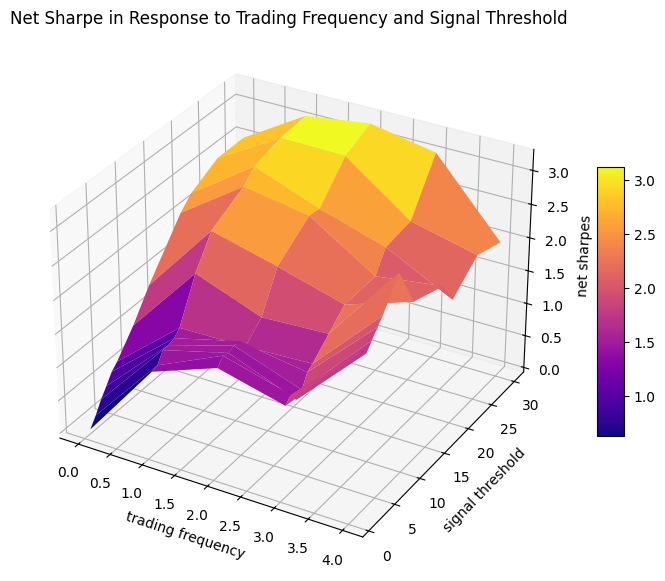

In [55]:
#plot_surface requires numerical values
#so in this case:
# 0 = 1h, 1 = 4h, 2 = 8h, 3 = 12h, 4 = 1d
x_vals = np.arange(len(x_vals))
X, Y = np.meshgrid(x_vals, y_vals)

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(X, Y, Z, cmap='plasma')

# Labels
ax.set_xlabel('trading frequency')
ax.set_ylabel('signal threshold')
ax.set_zlabel('net sharpes')
ax.set_title('Net Sharpe in Response to Trading Frequency and Signal Threshold')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.show()